# Learning to play the game of Go without human input

In Lecture 9, we have learned about multi-agent systems and adverserial games. A central algorithm in game playing is **MiniMax**.

MiniMax essentially searches the entire space of moves possible by both players at any given time till the game reaches an end. This is how it maximizes reward while the opponent is trying to minimize it. We saw an optimization called alpha-beta pruning for MiniMax which is a great improvement but only by a factor of 2. This might help in games such as chess (an AI agent can be twice as smart on the same computer now assuming it uses a plausible heuristic).

TicTacToe has $3^9 = 19683$ possible states, roughly half of them are valid states. This kind of state space can be fully searched by computers.

Some games such as Go are way too complicated.

By [one estimate](https://www.google.com/search?q=2081681993819799846994786333448627702865224+5388453054842563945682092741961273801537852+5648451698519643907259916015628128546089888+314427129715319317557736620397247064840935&filter=0&biw=1280&bih=627) there are:

```
2081681993819799846994786333448627702865224
5388453054842563945682092741961273801537852
5648451698519643907259916015628128546089888
314427129715319317557736620397247064840935
```

States!

That certainly cannot be handled by even the biggest supercomputers or an earth filled with GPUs.


Go is a [googol](https://en.wikipedia.org/wiki/Googol) ($10^{100}$) times more complex than chess. It has more states than there are atoms in the universe. It has been a formidable challenge for AI.


In March 2016 DeepMind's AlphaGo Lee became the first program to beat a human expert -- 18-time world champion Lee Sedol. (DeepBlue beat Gary Kasparov in chess in 1997 -- super human ability in Go took 19 years longer).

The key insight of this software was to use a neural network to learn the game by looking at how humans play (using plays from ameteur players on internet Go servers) it to begin with, but later by playing the program against itself.

In 19 Oct 2017 DeepMind unweiled a newer, more elegant version of AlphaGo -- the AlphaGo Zero. This version learnt the game all on its own through playing millions of games with its best self. In 3 days, AlphaGo Zero trained enough to beat the first version (AlphaGo Lee) 100 games to 0! In this notebook we will look at the technique carried out in this "training". We also implment the algorithm on the game of Tictactoe and allow you to explore how the skill of the agent improves as it learns to play better.

## Background

### Monte carlo tree search (MCTS)


![](https://nikcheerla.github.io/deeplearningschool//media/branching.jpg)

One way to non-exhaustively search a large state space graph is to **pick a random sample of branches**, play each one many times (repeating random selection) to see which ones result in a victory down the road more often. This is called Monte-carlo tree search.

While playing a number of random games we can store the reward for all plays so far from a given state. At a later time we can commit to using these statistics as the "prior" for the random sampling of branches (i.e. higher the probability of winning, the more likely the branch will be sampled, but also with an element of exploration.)

Below, we will learn and implement MCTS on the tic tac toe game.

##### Setting up Julia packages

The following cell should install all the dependencies to run this notebook. Ignore any build errors to do with CUDAnative and CUDAdrv packages, these are not required but are installed by default by the AlphaGo implementation.

You will have to restart the Jupyter notebook server and start this notebook again to get some of the UI packages to work (this will let you play Tic tac toe against agents of different skill levels :-) )

In [1]:
# This sets up the Julia environment with the required packages
using Pkg
Pkg.activate("env") # like virtualenv we have some package state files here
Pkg.resolve()       # installs all the dependencies

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Fetching: [========================================>]  100.0 %.0 % Resolving package versions...
  Updating `~/code/16413-project/alphago-tictactoe/part2-alphago-zero-tictactoe/env/Project.toml`
 [no changes]
  Updating `~/code/16413-project/alphago-tictactoe/part2-alphago-zero-tictactoe/env/Manifest.toml`
 [no changes]


**Building MCTS**

Below is the simple Julia code which implements a simple form of MCTS for the game of tic-tac-toe.

We represent each state a little tiny matices. 0 is an empty cell, 1 is X and -1 in O.

Here's the start state

In [3]:
include("optimal.jl") # Load some game functions and the optimal player

┌ Info: Recompiling stale cache file /home/shashi/.julia/compiled/v1.0/StatsBase/EZjIG.ji for StatsBase [2913bbd2-ae8a-5f71-8c99-4fb6c76f3a91]
└ @ Base loading.jl:1187
┌ Info: Recompiling stale cache file /home/shashi/.julia/compiled/v1.0/AlphaGo/hIRw1.ji for AlphaGo [da2c498e-f8db-5b64-9cc4-315cb361752b]
└ @ Base loading.jl:1187


load_tictactoe_nn (generic function with 1 method)

In [4]:
start_state # sometimes compactly printed [0 0 0; 0 0 0; 0 0 0] (one row at a time)
# SArray stands for StaticArray -- these are small arrays whose sizes are fixed
# (CS trivia -- they can be stack allocated!)

3×3 SArray{Tuple{3,3},Int8,2,9}:
 0  0  0
 0  0  0
 0  0  0

`next_states` function returns all available next moves and the state they lead to

In [5]:
next_states(@SArray([0 0 0; 0 1 0; 0 0 0]), O) # play with different input states, e.g. [0 0 0; 0 1 0; 0 -1 0] and player X

8-element Array{Tuple{Tuple{Int64,Int64},SArray{Tuple{3,3},Int64,2,9}},1}:
 ((1, 1), [-1 0 0; 0 1 0; 0 0 0])
 ((2, 1), [0 0 0; -1 1 0; 0 0 0])
 ((3, 1), [0 0 0; 0 1 0; -1 0 0])
 ((1, 2), [0 -1 0; 0 1 0; 0 0 0])
 ((3, 2), [0 0 0; 0 1 0; 0 -1 0])
 ((1, 3), [0 0 -1; 0 1 0; 0 0 0])
 ((2, 3), [0 0 0; 0 1 -1; 0 0 0])
 ((3, 3), [0 0 0; 0 1 0; 0 0 -1])

### Selection

At any state, we need to **select** a possible next move based on statistics from previously playing the game. Let's suppose we are tracking the following statistics for each state:

- Total (final) score for all games which had this state in their play -- call this $r_s$
- Total number of times this state was reached -- call this $n_s$

But we do not want to always select branches which previously have given us higher score, because there maybe other branches which may give us even higher score. So we need to give an opportunity for every possible move to be selected. However you do want to weight such games in a profitable way.

A theoretically optimal selection weight has been found called UCT (Upper Confidence Bound 1 applied to trees) which goes like:

$$weight = {r_s \over n_s} + c\sqrt{\log{n_p}\over n_s}$$

Where weight is the weight with which we should chose state $s$, $r_s$ and $n_s$ are as defined above and $n_p$ is the number of times the parent state has been reached so far.

Below we implment this formula as the function `uct`.

In [6]:
# Upper Confidence Bound 1 applied to trees
function uct(w, n, nₚ)
    w/n + (√2) * √(log(nₚ)/n)
end


uct (generic function with 1 method)

the selection itself is implemented by `mcts_move` below. It takes:

1. `state` -- the current state
2. `player` -- the player to play next
3. `stats` -- a dictionary which maps every state $s$ to its respective $(r_s, n_s)$ statistics.

It returns a move sampled using the weights calculated by the UCT formula.



In [11]:
function mcts_move(state, player, stats)
    succ = next_states(state, player)
    prior_vec = [get(stats, s[2], (0,1)) for s in succ]
    _, nₚ = get(stats, state, (0,1)) # parent count
    ns = last.(prior_vec); ws = first.(prior_vec)
    weights = uct.(player*ws, ns, nₚ)
    idx = sample(1:length(succ), Weights(weights), 1)[1]
    # sample a branch by weights
    succ[idx][1] # return the position
end

mcts_move (generic function with 1 method)

In [12]:
## Input
## - the stats dictionary
## - the trace of a game (all states from begining to end)
## - the final score
## Result: updates the stats dictionary with newer stats
##    for all states in trace

function update_stats!(stats, trace, score)
    for s in trace[2:end] # leave out start state
        # for each state we keep a sum of scores and the
        # number of times the state was reached
        sum, count = haskey(stats, s) ? stats[s] : (0, 0)
        sum += score
        count += 1
        stats[s] = (sum, count)
    end
end



## Play vs a random guessing player
## update=true will learn from game play rather than just play it with current skill
function play_mcts_vs_random(state, priors, player=X; update=true)
    play_f((s, pl) -> mcts_move(s, pl, priors),
         (s, pl) -> rand(next_states(s, pl))[1], state,
         player, update=update, priors1=priors, priors2=priors)
end


## Play a game against 2 mcts players
## update=true will learn from game play rather than just play it with current skill
function play_mcts_vs_mcts(state, priors1, priors2, player=X; update=true)
    play_f((s, pl) -> mcts_move(s, pl, priors1),
         (s, pl) -> mcts_move(s, pl, priors2),
         state, player, update=update,
         priors1=priors1, priors2=priors2)
end


## Play a game against an MCTS player vs an optimal player
## update=true will learn from game play rather than just play it with current skill
function play_mcts_vs_optimal(state, priors, player=X; update=true)
    play_f((s, pl) -> mcts_move(s, pl, priors),
         (s, pl) -> minimize(s, pl)[3], state,
         player, update=update, priors1=priors, priors2=priors)
end


play_mcts_vs_optimal (generic function with 2 methods)

Let's play a hundred games to accumulate some statistics just to look at the format

In [13]:
# We will use this stats dictionary to play and track statistics
stats = Dict{State, Tuple{Int,Int}}()

for i=1:100
    play_mcts_vs_random(start_state, stats)
end

stats

Dict{SArray{Tuple{3,3},Int8,2,9},Tuple{Int64,Int64}} with 347 entries:
  Int8[1 0 -1; 1 0 -1; 0 -1 1]  => (1, 1)
  Int8[1 0 -1; 1 -1 0; 1 0 0]   => (1, 1)
  Int8[1 0 -1; 0 0 0; 0 0 0]    => (2, 14)
  Int8[1 0 0; 0 1 -1; 0 0 0]    => (3, 3)
  Int8[1 0 0; 0 1 -1; -1 0 0]   => (2, 2)
  Int8[1 0 0; 1 -1 0; 0 0 0]    => (3, 3)
  Int8[1 -1 -1; 1 0 0; 0 0 1]   => (1, 1)
  Int8[1 0 1; 0 0 -1; -1 0 0]   => (1, 1)
  Int8[1 1 -1; -1 0 1; 1 0 -1]  => (0, 1)
  Int8[1 0 -1; 0 0 0; 0 -1 1]   => (-1, 1)
  Int8[1 0 0; 0 -1 -1; 0 0 1]   => (1, 1)
  Int8[1 -1 1; -1 -1 0; 1 1 0]  => (-1, 2)
  Int8[1 1 1; 1 -1 0; -1 -1 0]  => (2, 2)
  Int8[1 0 -1; 1 0 0; -1 0 0]   => (0, 2)
  Int8[1 0 0; 1 0 0; -1 -1 0]   => (1, 1)
  Int8[1 1 1; 1 -1 0; -1 0 -1]  => (2, 2)
  Int8[1 1 0; -1 0 0; 0 0 -1]   => (-1, 1)
  Int8[1 0 -1; 1 1 0; 0 -1 -1]  => (1, 1)
  Int8[1 0 1; -1 0 0; 0 0 0]    => (1, 2)
  Int8[1 -1 1; -1 -1 0; 1 1 -1] => (0, 1)
  Int8[1 -1 0; 1 0 -1; 1 -1 1]  => (1, 1)
  Int8[1 1 0; 1 -1 0; -1 0 0]   => (2, 2)
 

In [14]:
using Gadfly

"""
Assess a learning strategy against optimal player

f() - learns 1 game
stats - possibly used in `f` statistics for the player to asses
title - title of the plot
"""
function assess_mcts_learning(f, stats, title)
    number_of_states = Int[]
    skill = []
    games = [1, 10, 100, 1000, 10^4, 10^5]
    for sample_games in games
        for i=1:sample_games
            f()
        end
        push!(number_of_states, length(stats))

        # Play against optimal player while not learning
        plays = [play_mcts_vs_optimal(start_state, stats, update=false) for i=1:1000]
        push!(skill, plays)
    end
    
    p1 = plot(y=sum.(map(x->x.==0, skill))./10, x=games, Geom.line, Scale.x_log10,
     Guide.xlabel("Number of practice games"), Guide.ylabel("Skill (not lost out of 100)"), Guide.title(title))

    p2 = plot(y=number_of_states, x=games, Geom.line, Scale.x_log10,
         Guide.xlabel("Number of practice games"), Guide.ylabel("Storage size"))

    draw(SVG(20Gadfly.cm, 10Gadfly.cm), hstack(p1, p2))
end

assess_mcts_learning

# Playing with MCTS

### MCTS learning with a Random player

First we pit MCTS against a random guessing player, MCTS will learn as it plays many games. We show the skill level it reaches against after $10^i$ games for $\{i=0..5\}$

The maximum skill this MCTS network reaches is about 30 (games not lost against optimal)

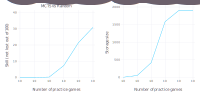

In [15]:
let stats = Dict{State, Tuple{Int,Int}}()
    assess_mcts_learning(stats, "MCTS vs Random") do
        play_mcts_vs_random(start_state, stats)
    end
end

## MCTS vs MCTS

Next we pit MCTS against itself! We update our stats using the triumphs and mistakes of both players (they use the same stats but look at it differently).

We see that in this case MCTS explored more states than random (Size vs practice games), but also reached a higher level of skill -- about 80.

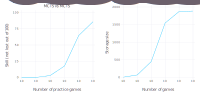

In [202]:
let stats = Dict{State, Tuple{Int,Int}}()
    assess_mcts_learning(stats, "MCTS vs MCTS") do
        play_mcts_vs_mcts(start_state, stats,stats)
    end
end

## MCTS vs Optimal

Next we pit MCTS against the optimal player! MCTS will gather stats while it plays against the best player in the world! As it keeps doing so, its skill comes alarmingly close to that of the optimal player.

We see that in this case MCTS explored much less states than random, and also reached the highest level of skill.

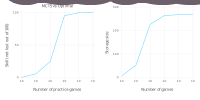

In [203]:
let stats = Dict{State, Tuple{Int,Int}}()
    assess_mcts_learning(stats, "MCTS vs Optimal") do
        play_mcts_vs_optimal(start_state, stats)
    end
end

### Questions you can pose with code:

1. How does your own weight making function (in place of uct) perform in training?
2. Run the code for up to 1 million simulations (this should take 1 minute for each part), does the skill get closer to optimal?
3. In the case of MCTS vs MCTS sometimes more training may result in lesser skill, how might this happen?

### Problems in extending MCTS to the game of Go

1. As we saw the state space of Go is too big! In our MCTS implementation, we used a stats dictionary which maps every state encountered to a statistic about its optimality. That approach may not scale.
2. An MCTS statistics table may get lost in smaller details such as simple moves while missing longer term strategy that may be available in a certain branch. For example, the Go board is symmetric, but we have twice the number of states (we can just flip the board laterally), there may be such symmetries within smaller regions of the board as well.



### Neural netwoks to make MCTS ligher, and smarter


An artificial neural network is a function $f$ that can be "train"ed to approximate another function $g$.
 
$f$ is usually a series of linear combinations of the inputs with adjustible weights. Sometimes there may be non-linear functions (such as sigmoid) thrown into the mix to approximate non-linear $g$s.

Imagine that each node in the picture below represents a weight, all arrows coming into it are multiplied by the weight and summed to produce the output. Sometimes the node may also apply a non-linear function such as sigmoid to the output.
![](https://upload.wikimedia.org/wikipedia/commons/thumb/4/46/Colored_neural_network.svg/296px-Colored_neural_network.svg.png)

To train the neural network to approximate $g$ better, we first take some sets of $\langle x_i, g(x_i)\rangle$ and "adjust" weights in $f$ so that $f$ gets better at generating the output $g(x_i)$ when $x_i$ is the input. The exact technique for this adjustment is outside the scope of this notebook, and should not matter here.

![](https://cdn-images-1.medium.com/max/1600/1*yg9-6oLTAX0sVeLBJudexA.png)
_A neural network that approximates some function._

AlphaGo zero creates a neural network $f_{\theta}$ which approximates the probability distribution among all branches for the next move. Then the sampling algorithm draws from this probability distribution. It also uses the same neural network to guess the expected probability of winning from the state it is applied to.


$$(\textbf{p}, v) = f_{\theta}(s)$$

Here $\textbf{p}$ maps every action available at state $s$ to a probability value that it should be sampled.

**Convolution**

We mentioned above that some states in Go maybe symmetrically similar to others. Moreover there maybe features such as a clustering of go pellets or "being surrounded". A related problem in computer vision is identifying objects regardless of their orientation or scale in an image (which is a checkerboard of pixels). Computer vision has found many techniques to adapt neural networks for this purpose, one of them is convolutional networks. Convolutional networks produce weighted averages that can encode things like size shape and direction.

Here's an animation that gives an intuition of how a convolutional layer of weights looks:

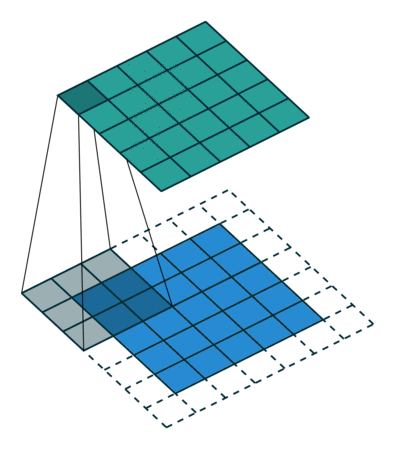

A convolutional network in computer vision trying to identify a car:

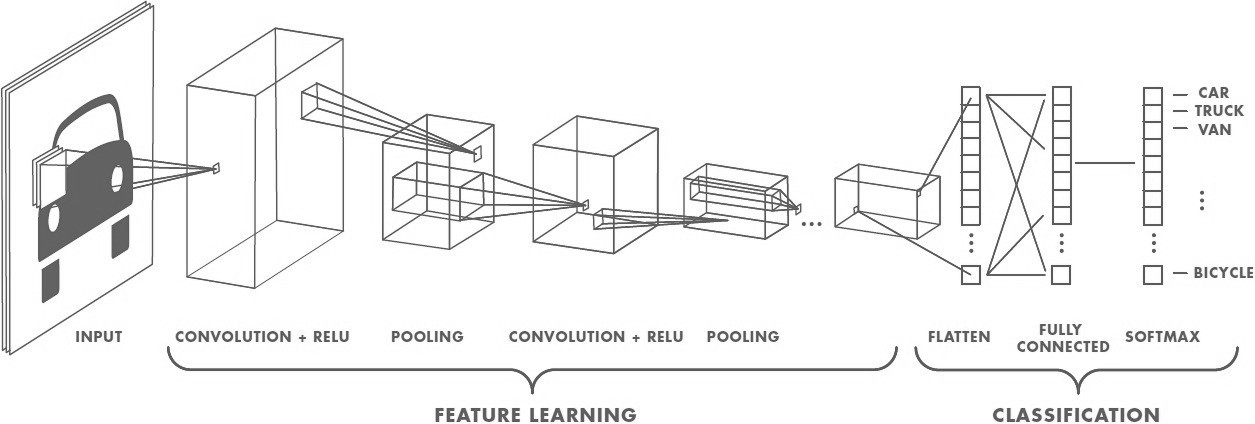

AlphaGo Zero uses convolutional networks to represent abstract patterns developing on the Go board -- and this guides MCTS selection! This is the genius of the algorithm.


**Self-play**

A neural network needs to be told which are good moves and which are not in order to train itself to be better at the game. AlphaGo Zero keeps improving by playing against itself. Winning the game gets a reward of 1, losing gets a reward of -1.


### Assembling the algorithm

So, this is the simple algorithm that runs all of AlphaGo Zero!

- Create a neural network $f_theta$ to approximate the sampling weights for branches in a monte carlo search

$$(\textbf{p}, v) = f_{\theta}(s)$$

- Until the world champion can be defeated:
  -   Play a game against the best version of yourself, observe the results
  -   Update neural network to better approximate MCTS weights $\textbf{p}$.

## Notes about implementation

For the purpose of this presentation we chose [AlphaGo.jl](https://github.com/tejank10/AlphaGo.jl) a Julia implimentation of AlphaGo Zero algorithm. The package not only implements the algorithm for Go, but also for the game of [Gomoku](https://en.wikipedia.org/wiki/Gomoku) which is a **generalization of Tic-tac-toe** played on the Go board. The program allows you to tweak the size of the board and the number of squares that need to be taken up consequitively to win the game. Hence Tic Tac Toe is a special case of Gomoku when the board is of size 3x3 and you need 3 colinear squares to win.

See appendix for more about the structure of the neural networks we tested.

In [16]:
include("ui.jl") # The game-playing UI code

┌ Info: Recompiling stale cache file /home/shashi/.julia/compiled/v1.0/WebIO/v9IED.ji for WebIO [0f1e0344-ec1d-5b48-a673-e5cf874b6c29]
└ @ Base loading.jl:1187


HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/62ae700519013cd1c4d3a5c4b99bff8a78ae8c45-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/62ae700519013cd1c4d3a5c4b99bff8a78ae8c45-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

┌ Info: Recompiling stale cache file /home/shashi/.julia/compiled/v1.0/InteractBase/63c8J.ji for InteractBase [d3863d7c-f0c8-5437-a7b4-3ae773c01009]
└ @ Base loading.jl:1187


LoadError: UndefVarError: px not defined

### Playing against the neural network

Below is a UI where you can play against the neural network at various stages of its learning.

In the cell immediately below, the neural network has been only trained on 10 games.

The agent is smart to win or draw most games already, but try playing (1,1), (3,3), (1, 3), (1, 2) -- you will win this game. (note: $(i,j)$ is $i^{th}$ row $j^{th}$ column.)

In the subsequent cells you can adjust the level of training the Neural network has had and play the same game to see where the Neural network figured out to draw this game.

In [17]:
# there are 50 levels we have trained, second argument is the level

games_played = [0, 1, 2, 5, 10, 50, 100, 200] * 10

nn = load_tictactoe_nn("models_final", "0")

# play_with lets you play the game with any given neural network
b,t = play_with(nn)
b # -- this is the board, and gets interactively displayed

# NOTE: once you click on a square it may take several seconds for the first move to be registered
# Julia is a just-in-time compiled language, the first move compiles the whole
# program to C-like machine code, hence be patient

UndefVarError: UndefVarError: play_with not defined

### Play with an agent which has various levels of training!

In [215]:
@manipulate for level = slider([0, 1, 2, 5, 10, 50, 100, 200] .* 10, label="Experience level (practice games): ", value=1)
    nn = load_tictactoe_nn("models_final", string(Int(level))) # there are 50 levels we have trained, second argument is the level

    play_with(nn)[1]
end

InexactError: InexactError: Int64(Int64, 0.1)

In [13]:
include("optimal.jl")

## Comparison against optimal player over time

The true test of skill for the neural network is comparison against the optimal policy for the game. Fortunately, in the game of Tic tac toe we can actually have do this. We have written an optimal player in `optimal.jl` file, it is in the same vein as the one in Homework 6. If you are curious about how the Julia code looks, you may have a look in there. We also have a function play_optimal which will play against a given neural network and return the result 1 if the optimal player wins 0 if a draw and -1 if the neural network wins (this never happens, since if all players played optimally there can only ever be a draw).

If you play every level of the NN player against the optimal player many times, you can plot what percentage of games a given level of player can draw or win, the plot hence shows the effectiveness of learning.

```julia
using Distributed
addprocs(4) # add 4 more Julia processors

stats = pmap(0:50) do i # run the evaluation in parallel
        nn = load_tictactoe_nn("models_final", string(i))

        println("at $i")
        plays = [play_nn_vs_optimal(nn) for i=1:200]
    end
end


using Gadfly
Gadfly.plot(y=(20 .- sum.(stats)) / 200 * 100, x=[1:50;] .* 10,
    Geom.point, Geom.smooth, Guide.xlabel("Games trained on "), Guide.ylabel("NN vs. Optimal (% not lost)"))
```

<img src="https://user-images.githubusercontent.com/25916/47750325-8f5f5f80-dc65-11e8-9a23-6dd0475d238a.png" width="600">

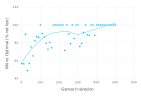

In [210]:
# I have run the above trial games and saved it onto disk
# For each level of player we ran 200 games against optimal player
using BSON

let optimstats = BSON.@load "stats.bson" stats
    Gadfly.plot(y=(200 .- sum.(stats)) / 200 * 100, x=[0:200;] .* 10 .+1,
        Geom.point, Geom.smooth, Guide.xlabel("Games trained on "), Guide.ylabel("NN vs. Optimal (% not lost)"))
end

## Appendix

**Blooper** We initially trained the network on 10000 games without considering the option `start_training_after` which is by default set to 50000 -- these are the number of sample branches explored. So our training did not start to learn anything until it played about 6000 games, but was sampling games to assign priors for the monte carlo tree search. However, once the training started the priors accumulated from the 6000 games were enough to quickly learn the optimal strategy. The plot below shows this.


<img src="https://user-images.githubusercontent.com/25916/47750905-cc782180-dc66-11e8-8ac8-b38a4154f26b.png" width="600">

However for the purpose of the examples here we went with the much lesser trained network of a setup where we only use 81 initial games to set the prior for the monte-carlo sampling. Also we only trained on 500 games and captured a snaptshot of the agent more frequently. This makes for a much more human-accessible example. You can actually play against the agent and see how dumb it started out and how it learned specific moves.


### Don Knuth takes a crack at TicTacToe in 10000 bytes

Here is Donald Knuth talking about solving the game of tic tac toe by training against an optimal player https://www.youtube.com/watch?v=_c3dKYrjj2Q . The idea of learning from self-play in AlphaGo are certainly not new, but the cleverness is in the monte carlo tree search. And of course the enormous amount of compute power required to train the network.

## References

- **Mastering the game of Go without human knowledge**  -- Nature (Oct. 2017)
David Silver, Julian Schrittwieser, Karen Simonyan, Ioannis Antonoglou, Aja Huang, Arthur Guez, Thomas Hubert, Lucas Baker, Matthew Lai, Adrian Bolton, Yutian Chen, Timothy Lillicrap, Fan Hui, Laurent Sifre, George van den Driessche, Thore Graepel & Demis Hassabis

- **AlphaGo Zero Explained - On AI** blog post https://nikcheerla.github.io/deeplearningschool/2018/01/01/AlphaZero-Explained/

- **AlphaGo.jl** - Julia implementation of the AlphaGo Zero problem on Go and Gomoku -- a generalization of tic-tac-toe

- **General Game playing with MCTS** blog post https://medium.com/@quasimik/monte-carlo-tree-search-applied-to-letterpress-34f41c86e238